In [1]:
import meep as mp
import meep.adjoint as mpa
import autograd.numpy as npa
from autograd import tensor_jacobian_product, jacobian
import numpy as np
from matplotlib import pyplot as plt
import nlopt
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5
arm_separation = 1.0
waveguide_length = 0.5
pml_size = 1.0
resolution = 20
filter_radius = 0.2
design_region_resolution = int(2.5*resolution)
update_factor = int(10)
beta_scale = 2
beta_start = beta_scale ** (-5)
maxeval=update_factor*15

Si = 3.4777
SiO2 = 1.4440

frequencies = 1/np.linspace(1.5,1.6,10)

In [3]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width
Sy = 2*pml_size + design_region_height + 0.5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

seed = 24
np.random.seed(seed)
Nx = int(design_region_resolution * design_region_width)
Ny = int(design_region_resolution * design_region_height)

def material_scaling(x):
    return (Si**2-SiO2**2)*x + SiO2**2
def mapping(x,sigma,delta,beta):
    return material_scaling(mpa.projection_filter(mpa.smoothing_filter(x,sigma,delta,Nx,Ny),sigma,delta,beta))

sigma = filter_radius * design_region_resolution # design parameter units
delta = 0
beta = 1

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = np.random.rand(Nx*Ny)
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=mapping(rho_vector,sigma,delta,beta),symmetry=[])

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=Si), size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=mp.Medium(index=Si), size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=mp.Medium(index=Si), size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.Medium(index=SiO2),
                    resolution=resolution)

In [4]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3),size=mp.Vector3(y=1.5)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,arm_separation/2,0),size=mp.Vector3(y=arm_separation)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,-arm_separation/2,0),size=mp.Vector3(y=arm_separation)),mode)
ob_list = [TE0,TE_top,TE_bottom]

In [5]:
def J(source,top,bottom):
    desired = 1
    power = npa.abs(top/source) ** 2 + npa.abs(bottom/source) ** 2
    return npa.sum(npa.abs(power - desired) ** 2)

In [6]:
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_variables = [design_variables],
    frequencies=frequencies,
    decay_by = 1e-4,
    decay_fields=[mp.Ez]
)

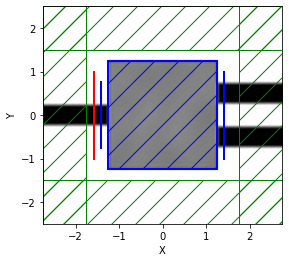

In [7]:
opt.plot2D(True)
plt.show()

In [8]:
evaluation_history = []
def f(x, grad):
    t = x[0]
    v = x[1:]
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t

In [9]:
evaluation_history = []
sensitivity = [0]
beta = [1]
cur_iter = [0]
final_inputs = np.zeros((Nx*Ny,))
def c(result,x,grad):
    print("Current iteration: {}/{}. Beta={}".format(cur_iter[0]+1,maxeval,beta[0]))
    t = x[0]
    v = x[1:]
    f0, dJ_deps, dg = opt([mapping(v,sigma,delta,beta[0])])
    if grad.size > 0:
        grad[:,0] = 0 # gradient w.r.t. "t"
        dJ_drhobar = design_variables.get_basis_vjp(dJ_deps,dg)
        for fi in range(frequencies.size):
            grad[fi,1:] = vector_jacobian_product(mapping,0)(dJ_drhobar[:,fi],sigma,delta,beta[0],dJ_drhobar[:,fi])
            #grad[fi,1:] = (jacobian(mapping,0)(dJ_drhobar[:,fi],sigma,delta,beta[0])@dJ_drhobar[:,fi]).transpose() # gradient w.r.t. "rho"
    evaluation_history.append(np.max(np.real(f0)))
    if cur_iter[0] % update_factor == 0:
        beta[0] = beta[0] * beta_scale
    cur_iter[0] += 1
    final_inputs[:] = v
    result[:] = np.real(f0) - t

In [10]:
evaluation_history = []
cur_iter = [0]
def f_simple(v, grad, cur_beta):
    print("Current iteration: {}/{}".format(cur_iter[0]+1,maxeval))
    
    f0, dJ_deps, dg = opt([mapping(v,sigma,delta,cur_beta)])
    plt.figure()
    opt.plot2D(False)
    plt.show()
    
    if grad.size > 0:
        dJ_drhobar = np.sum(design_variables.get_basis_vjp(dJ_deps,dg),axis=1)
        #grad[:] = jacobian(mapping,0)(v,sigma,delta,cur_beta)@dJ_drhobar   
        grad[:] = tensor_jacobian_product(mapping,0)(v,sigma,delta,cur_beta,dJ_drhobar)
    
    plt.figure()
    plt.imshow(np.rot90(grad.reshape(Nx,Ny)))
    plt.show()
    
    evaluation_history.append(np.max(np.real(f0)))
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

[0. 0. 0. ... 0. 0. 0.]
Current iteration: 1/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


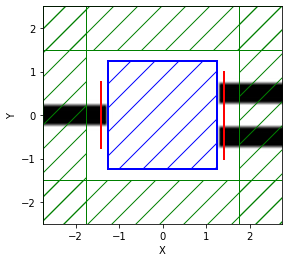

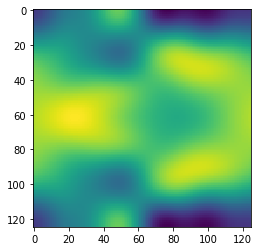

Current iteration: 2/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


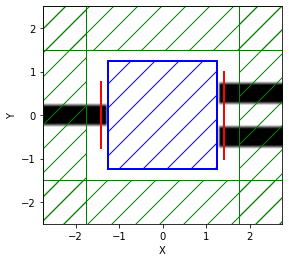

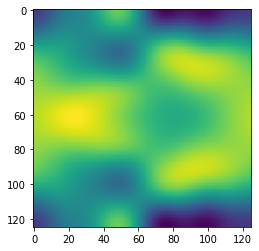

Current iteration: 3/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


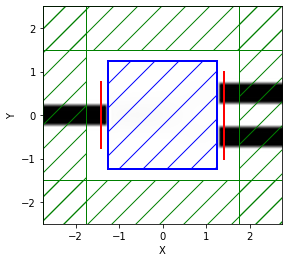

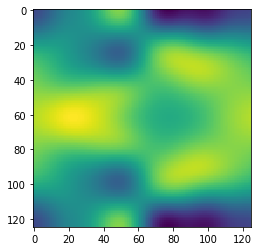

Current iteration: 4/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


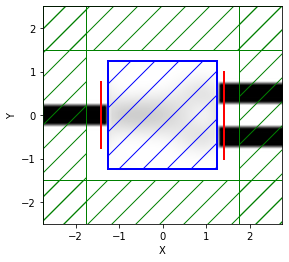

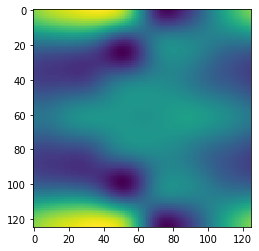

Current iteration: 5/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


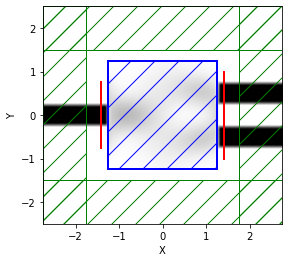

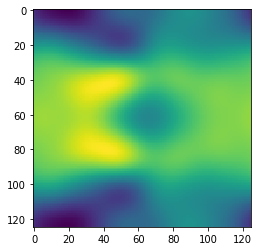

Current iteration: 6/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


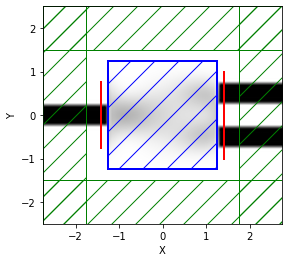

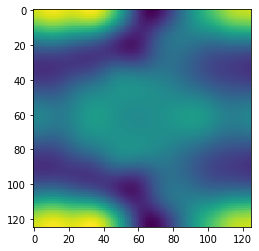

Current iteration: 7/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


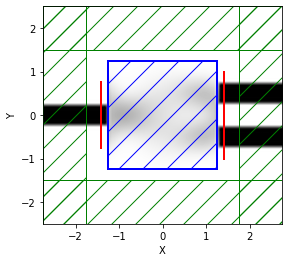

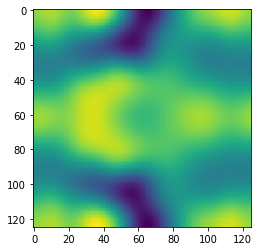

Current iteration: 8/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


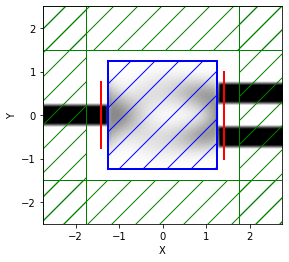

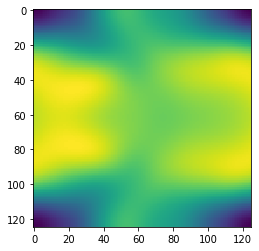

Current iteration: 9/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


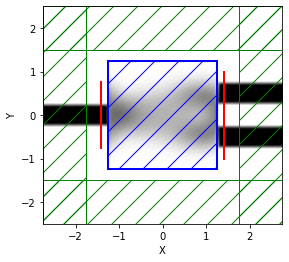

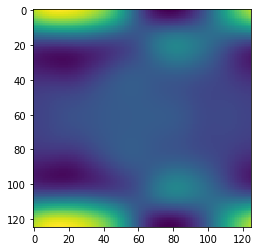

Current iteration: 10/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


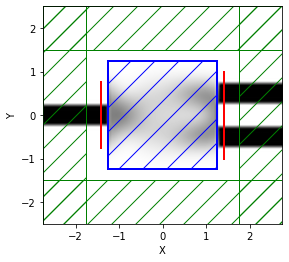

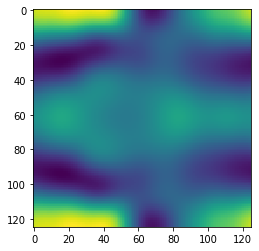

[0.1526644  0.15238652 0.15155241 ... 0.1499792  0.15138042 0.15222009]
Current iteration: 11/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


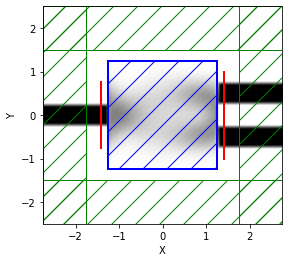

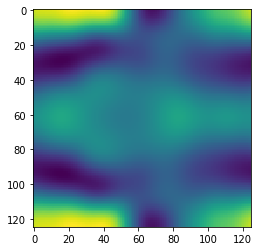

Current iteration: 12/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


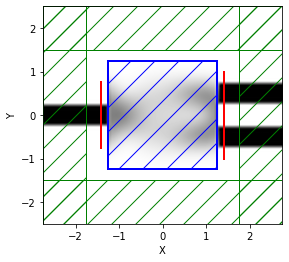

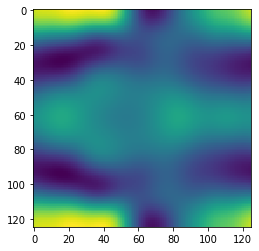

Current iteration: 13/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


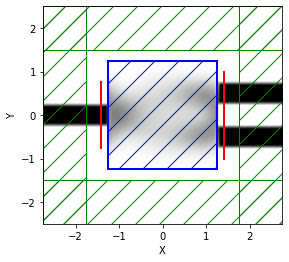

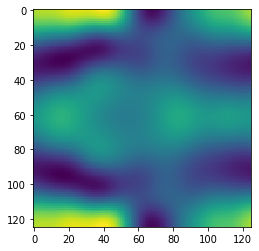

Current iteration: 14/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


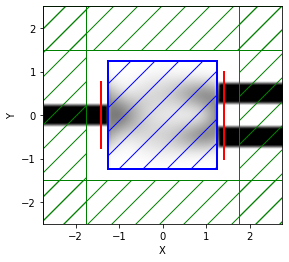

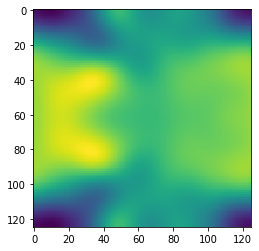

Current iteration: 15/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


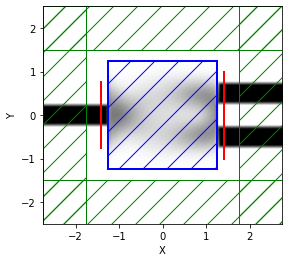

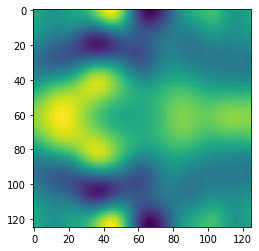

Current iteration: 16/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


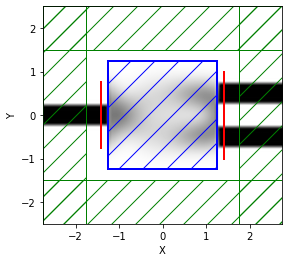

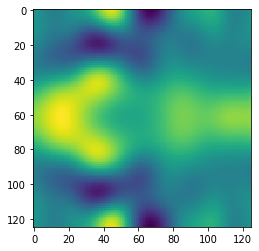

Current iteration: 17/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


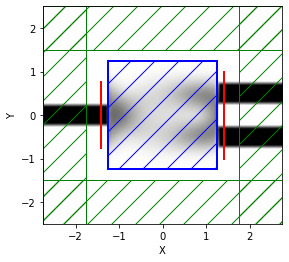

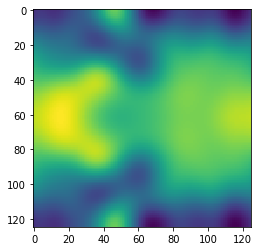

Current iteration: 18/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


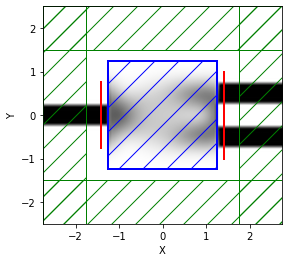

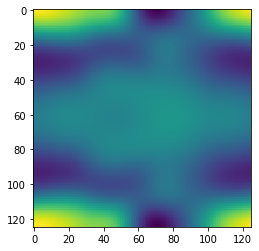

Current iteration: 19/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


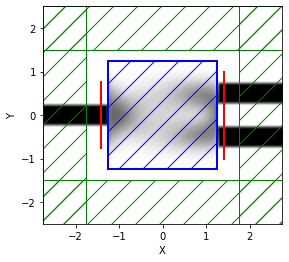

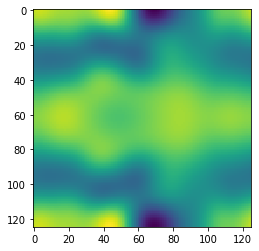

Current iteration: 20/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


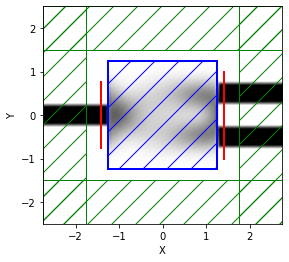

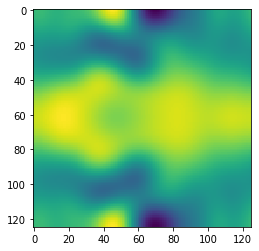

[0.13951396 0.13923527 0.13840383 ... 0.14018755 0.14164143 0.14252265]
Current iteration: 21/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


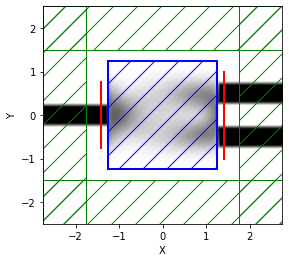

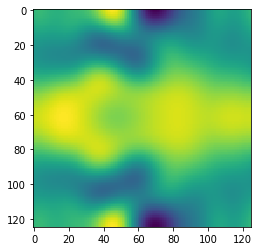

Current iteration: 22/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


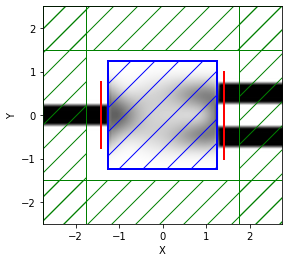

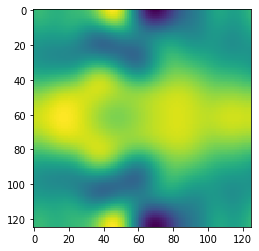

Current iteration: 23/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


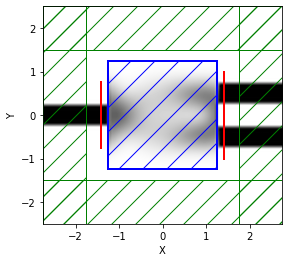

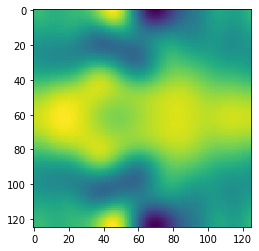

Current iteration: 24/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


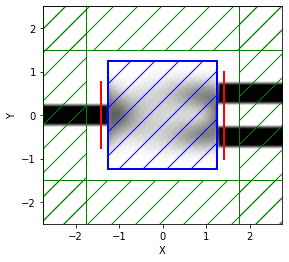

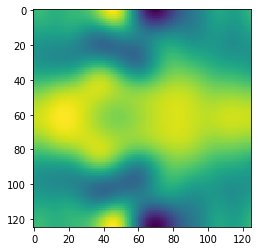

Current iteration: 25/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


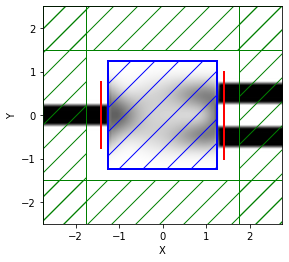

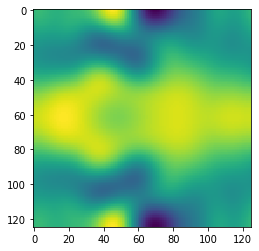

Current iteration: 26/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


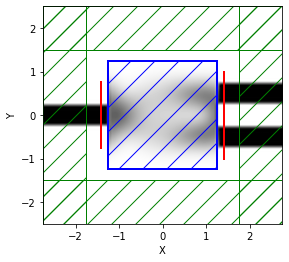

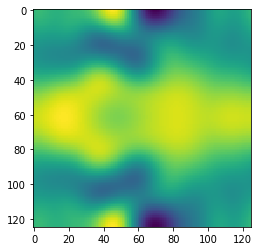

Current iteration: 27/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


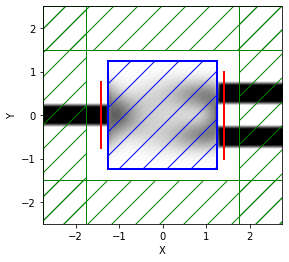

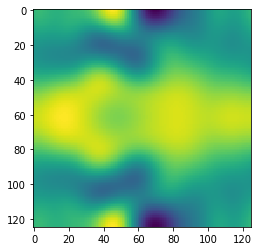

Current iteration: 28/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


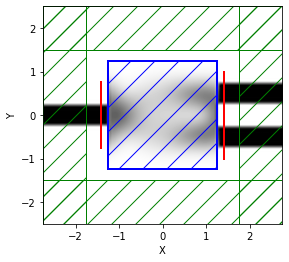

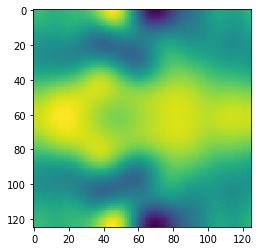

Current iteration: 29/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


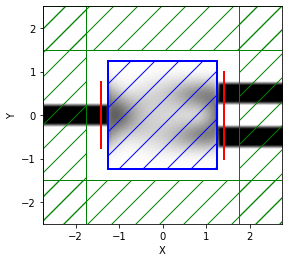

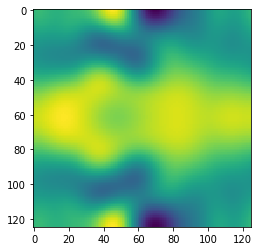

Current iteration: 30/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


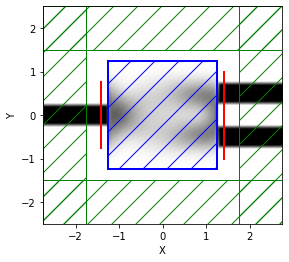

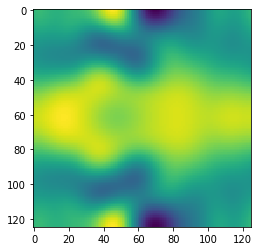

[0.14003786 0.13976074 0.13893397 ... 0.1407518  0.14219816 0.14307482]
Current iteration: 31/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


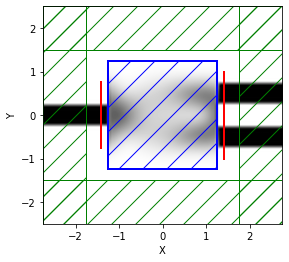

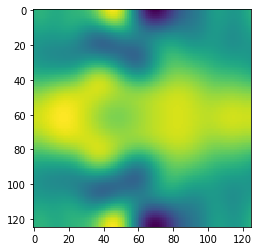

Current iteration: 32/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


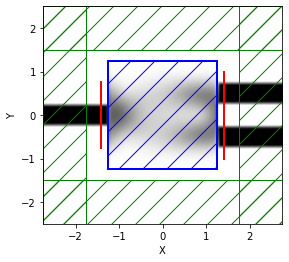

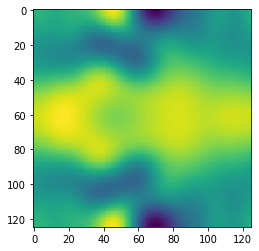

Current iteration: 33/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


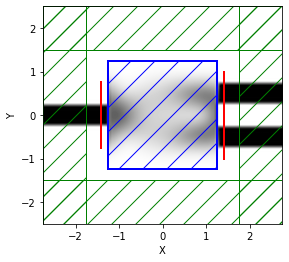

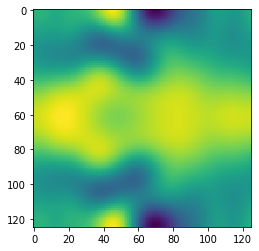

Current iteration: 34/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


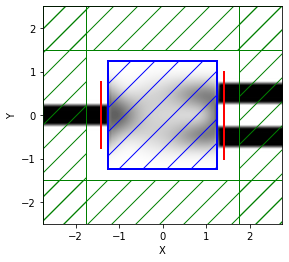

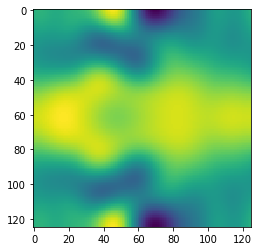

Current iteration: 35/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


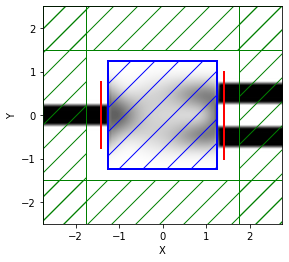

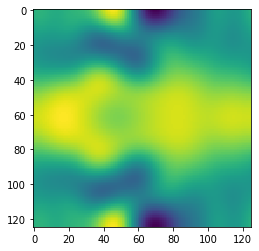

Current iteration: 36/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


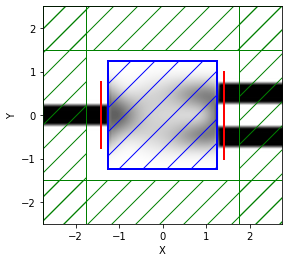

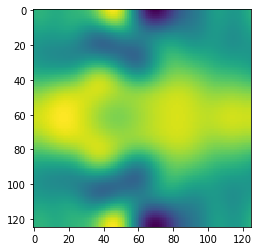

Current iteration: 37/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


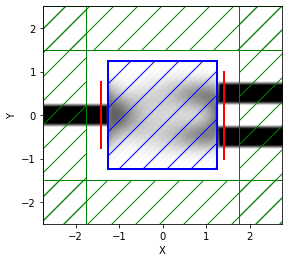

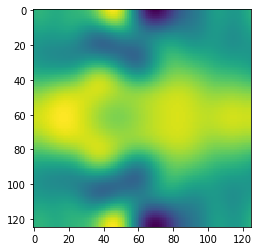

Current iteration: 38/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


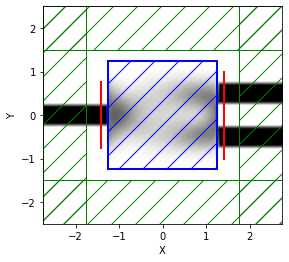

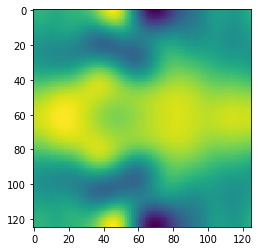

Current iteration: 39/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


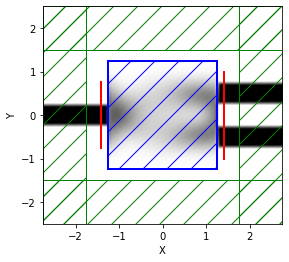

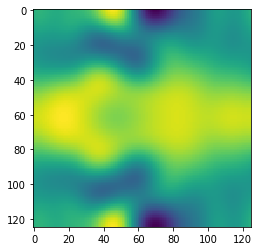

Current iteration: 40/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


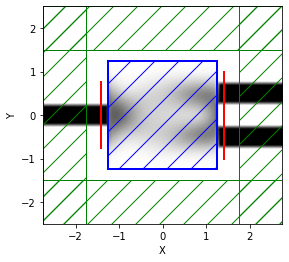

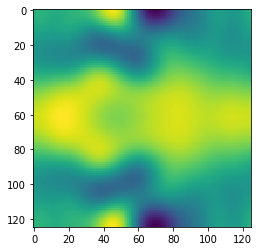

[0.14059594 0.14031998 0.13949669 ... 0.14134627 0.14278717 0.14366052]
Current iteration: 41/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


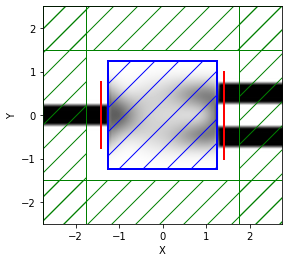

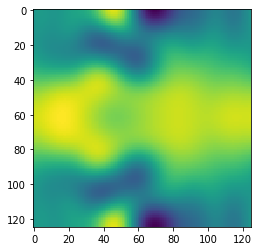

Current iteration: 42/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


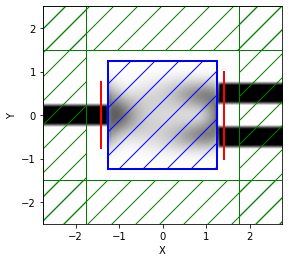

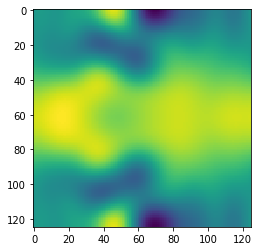

Current iteration: 43/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


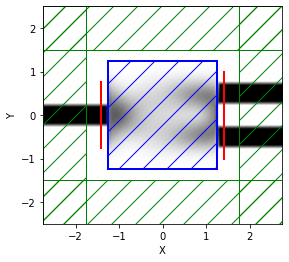

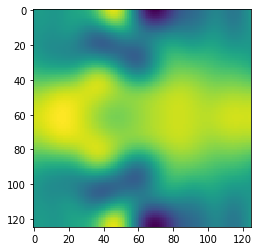

Current iteration: 44/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


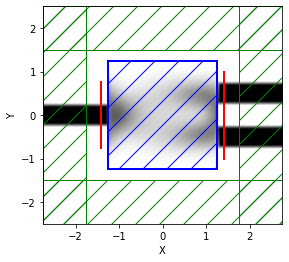

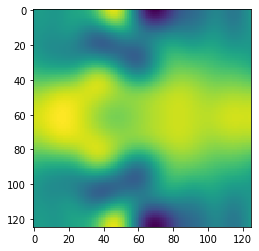

Current iteration: 45/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


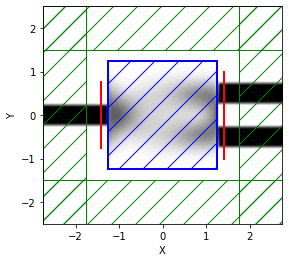

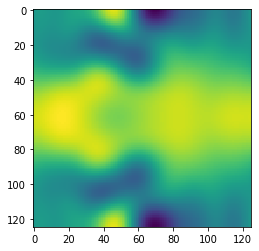

Current iteration: 46/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


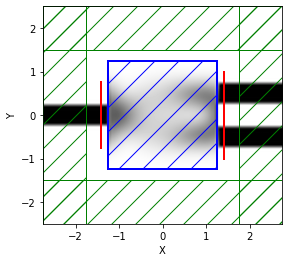

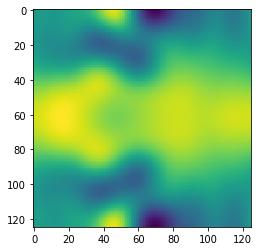

Current iteration: 47/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


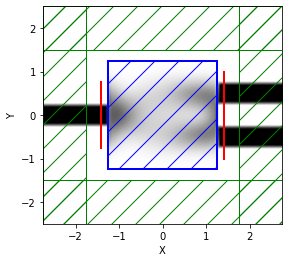

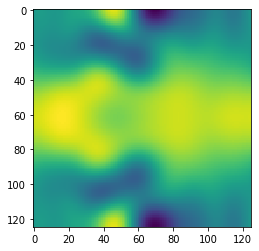

Current iteration: 48/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


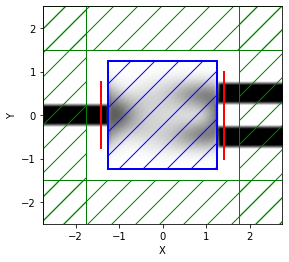

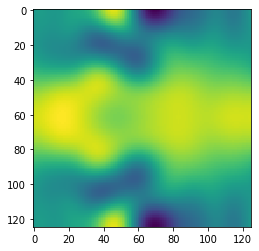

Current iteration: 49/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


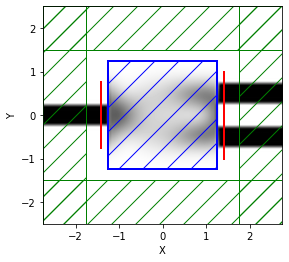

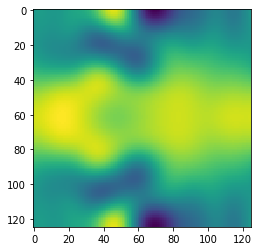

Current iteration: 50/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


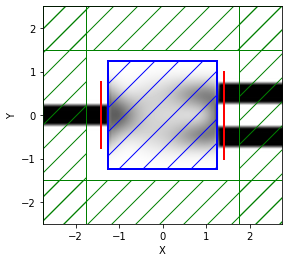

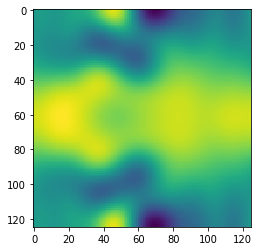

[0.14117767 0.14090182 0.14007887 ... 0.14195275 0.14339359 0.1442669 ]
Current iteration: 51/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


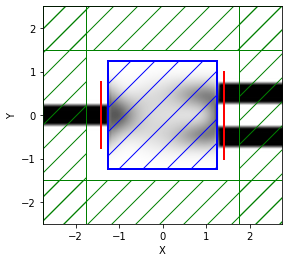

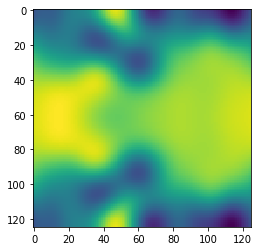

Current iteration: 52/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


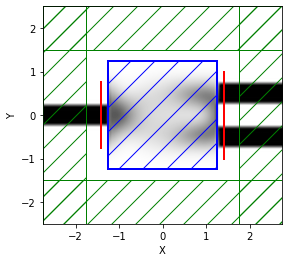

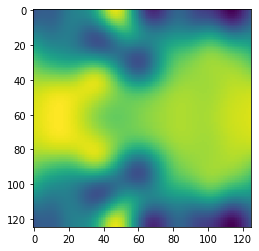

Current iteration: 53/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


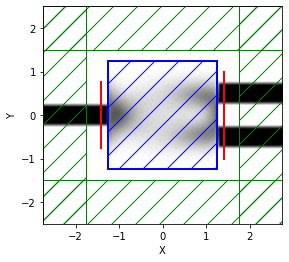

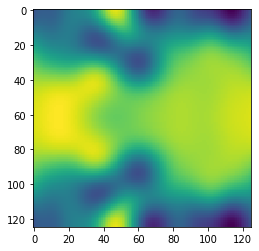

Current iteration: 54/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


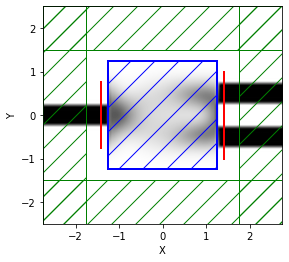

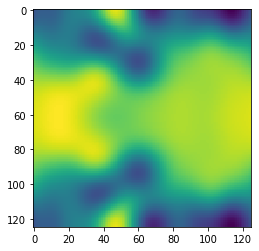

Current iteration: 55/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


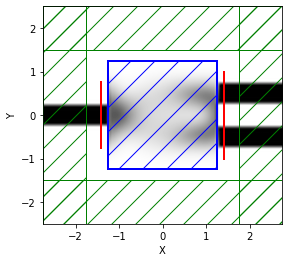

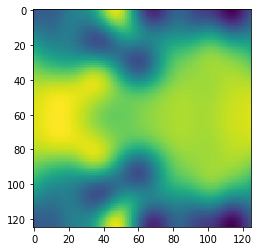

Current iteration: 56/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


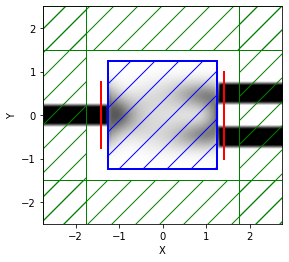

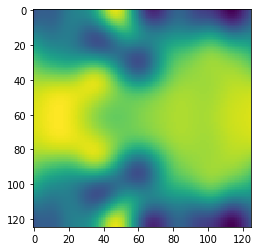

Current iteration: 57/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


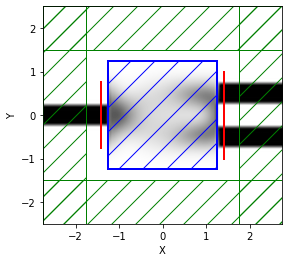

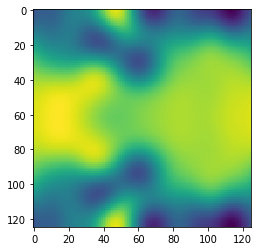

Current iteration: 58/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


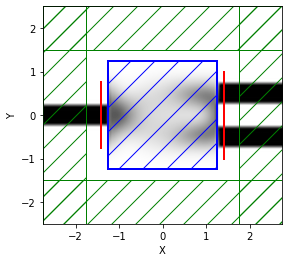

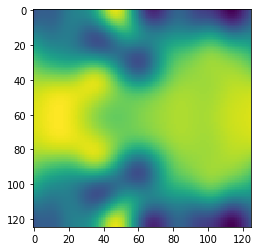

Current iteration: 59/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


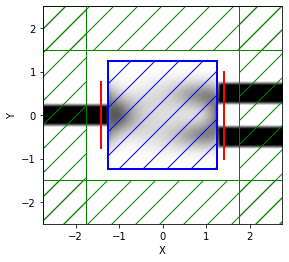

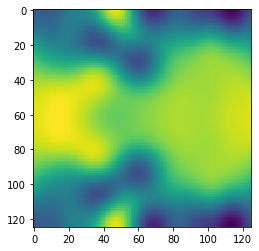

Current iteration: 60/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


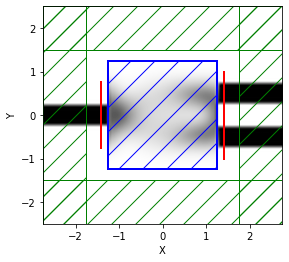

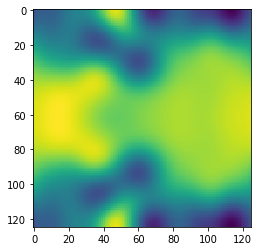

[0.14174426 0.14146719 0.1406406  ... 0.14253014 0.14397771 0.14485508]
Current iteration: 61/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


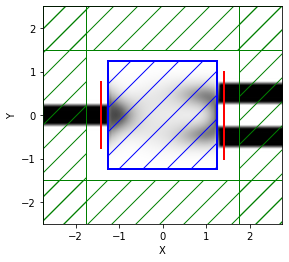

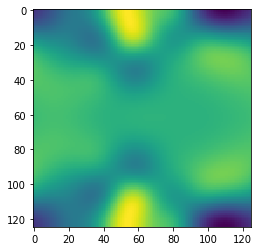

Current iteration: 62/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


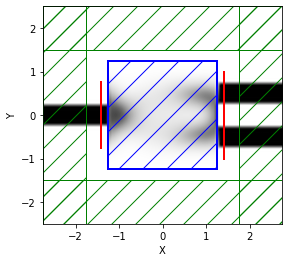

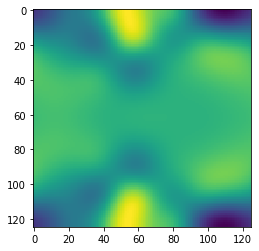

Current iteration: 63/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


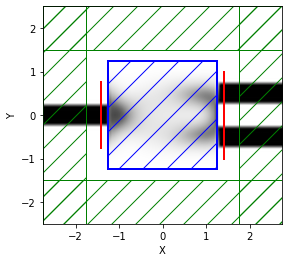

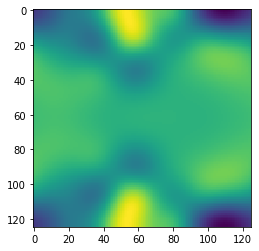

Current iteration: 64/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


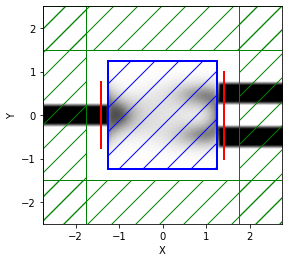

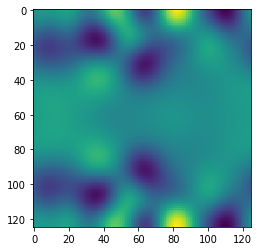

Current iteration: 65/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


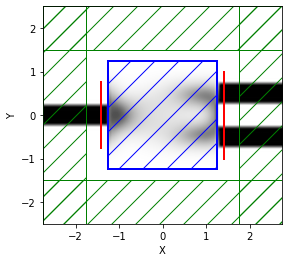

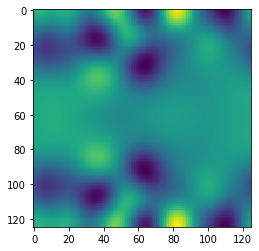

Current iteration: 66/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


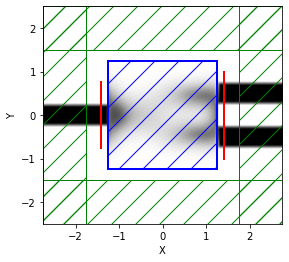

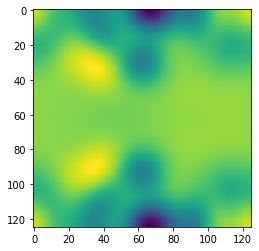

Current iteration: 67/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


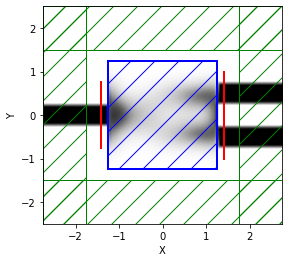

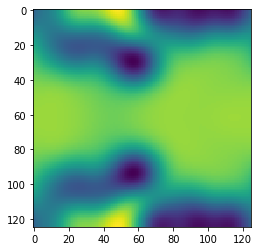

Current iteration: 68/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


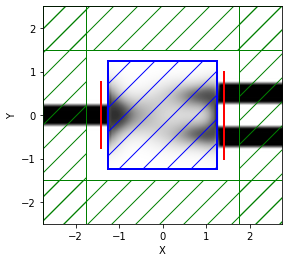

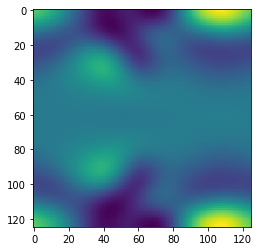

Current iteration: 69/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


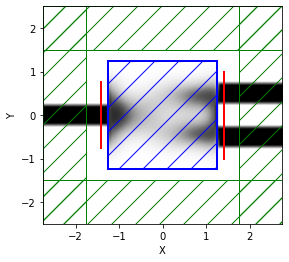

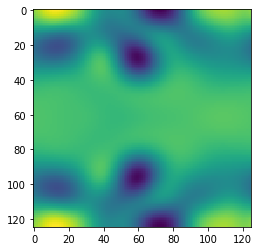

Current iteration: 70/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


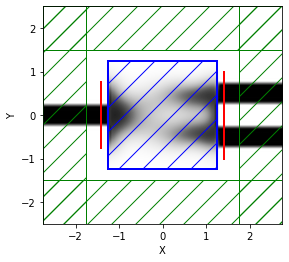

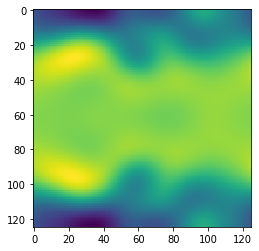

[0.13088043 0.13160499 0.13377615 ... 0.15068003 0.14757743 0.14571065]
Current iteration: 71/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


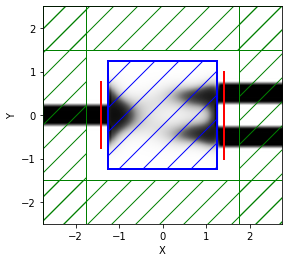

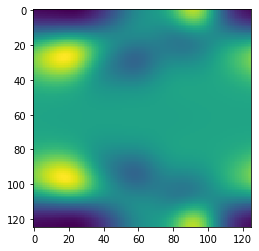

Current iteration: 72/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


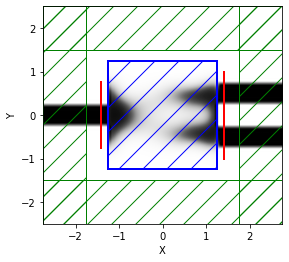

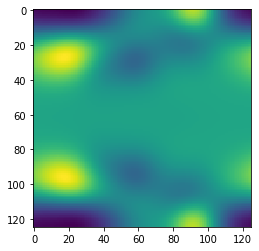

Current iteration: 73/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


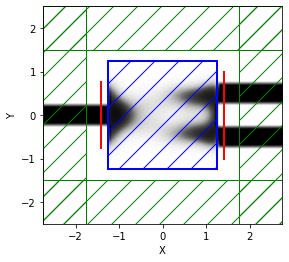

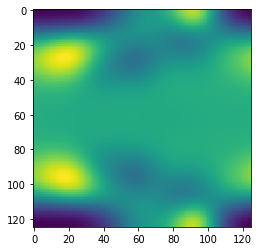

Current iteration: 74/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


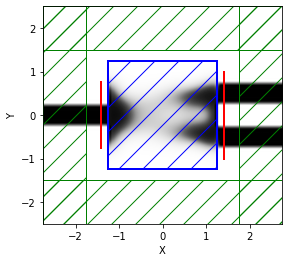

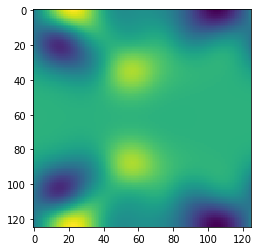

Current iteration: 75/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


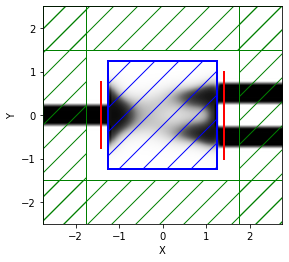

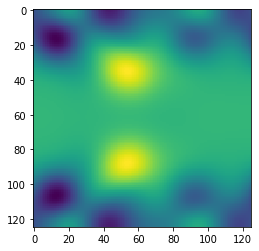

Current iteration: 76/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


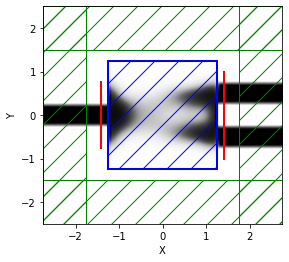

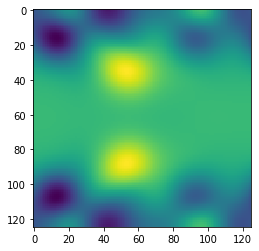

Current iteration: 77/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


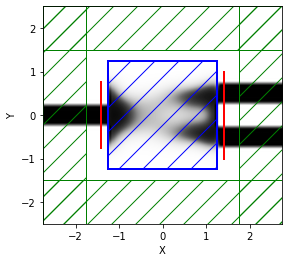

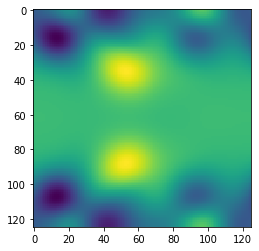

Current iteration: 78/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


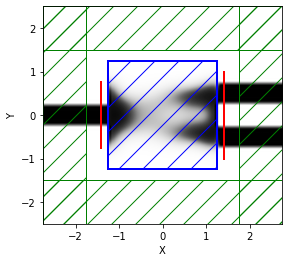

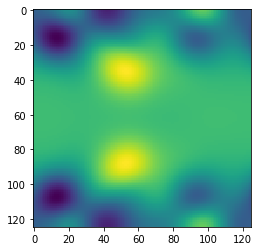

Current iteration: 79/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


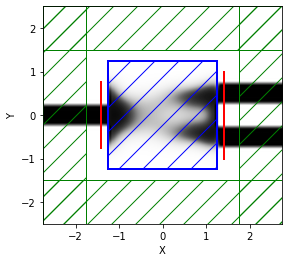

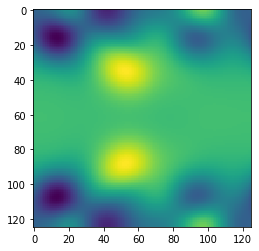

Current iteration: 80/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


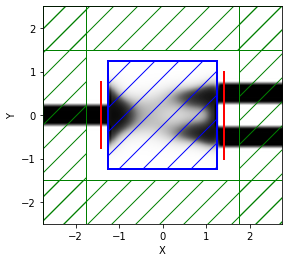

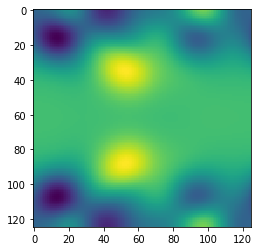

[0.28988707 0.29031614 0.29159791 ... 0.30837586 0.30691948 0.30603685]
Current iteration: 81/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


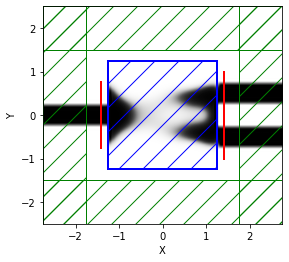

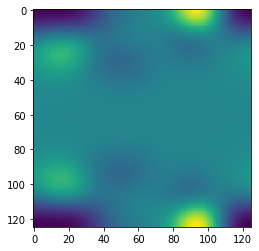

Current iteration: 82/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


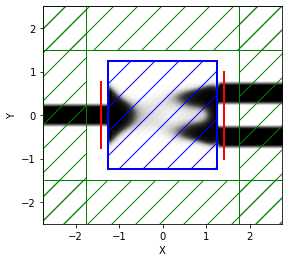

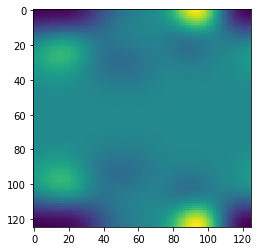

Current iteration: 83/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


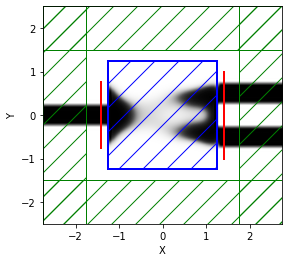

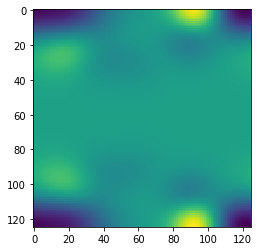

Current iteration: 84/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


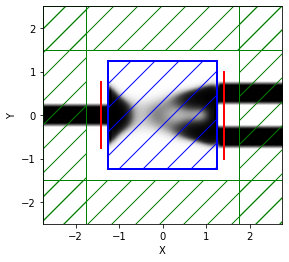

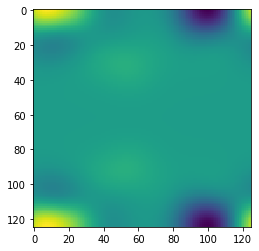

Current iteration: 85/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


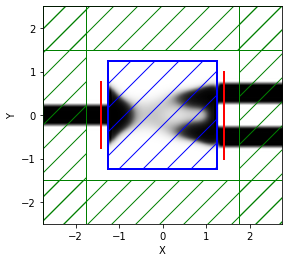

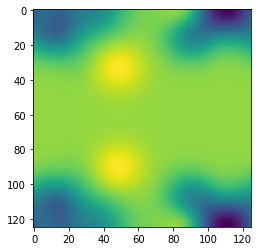

Current iteration: 86/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


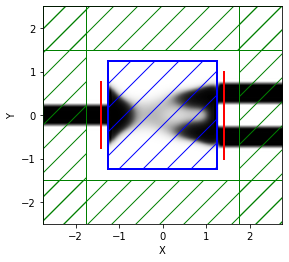

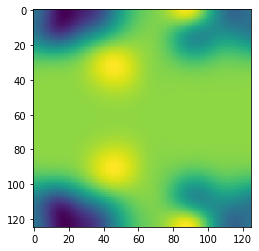

Current iteration: 87/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


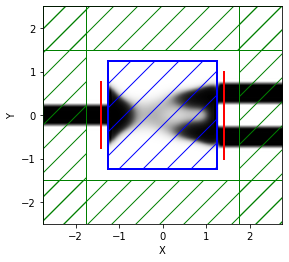

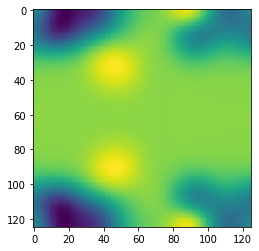

Current iteration: 88/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


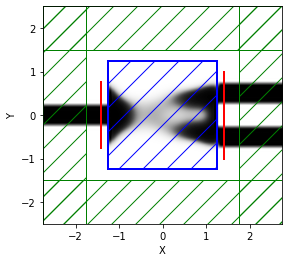

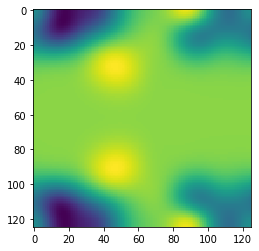

Current iteration: 89/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


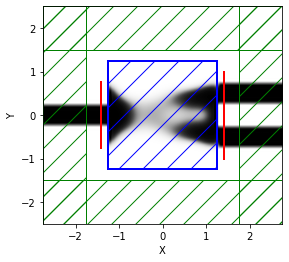

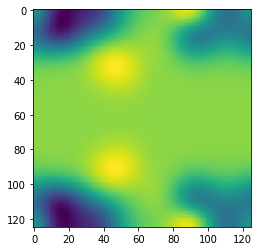

Current iteration: 90/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


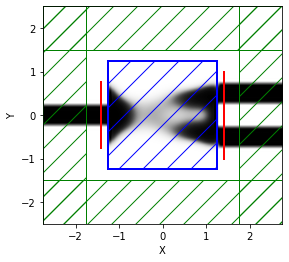

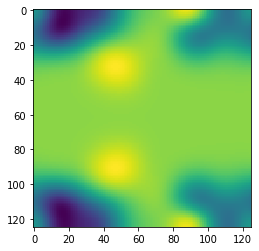

[0.39059626 0.39076712 0.39127489 ... 0.40745542 0.40733226 0.40725185]
Current iteration: 91/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


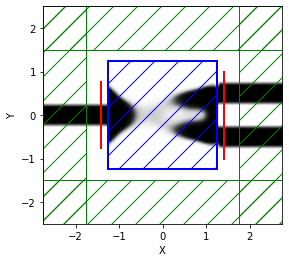

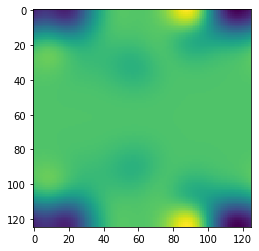

Current iteration: 92/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


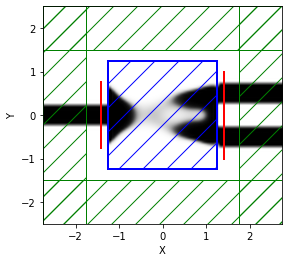

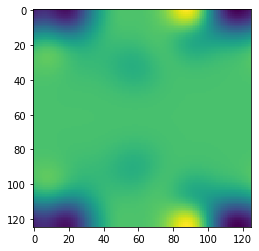

Current iteration: 93/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


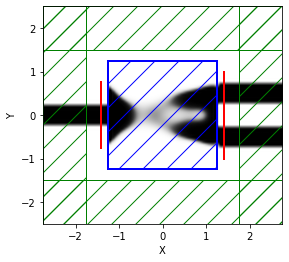

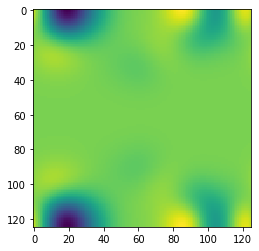

Current iteration: 94/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


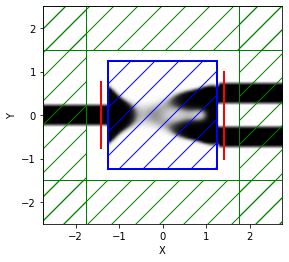

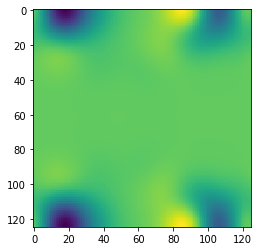

Current iteration: 95/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


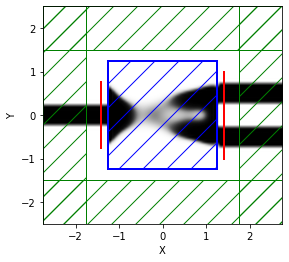

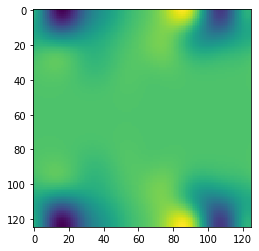

Current iteration: 96/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


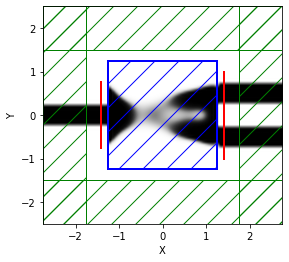

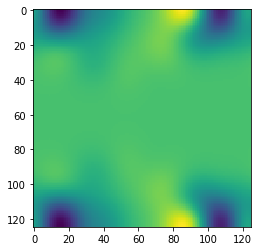

Current iteration: 97/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


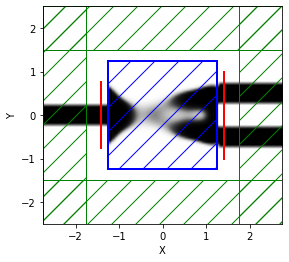

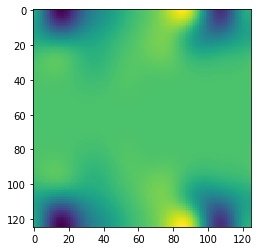

Current iteration: 98/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


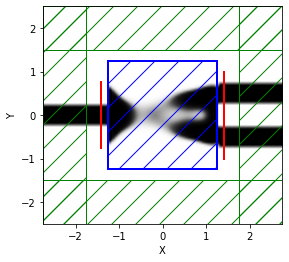

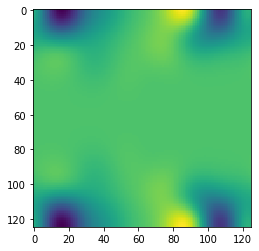

Current iteration: 99/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


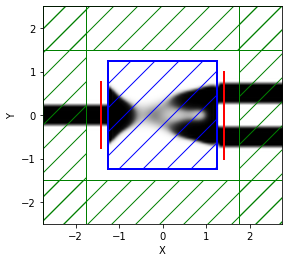

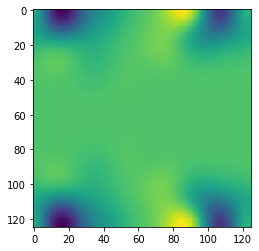

Current iteration: 100/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


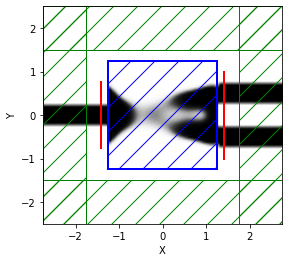

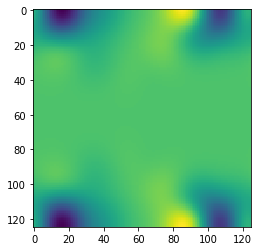

[0.41975355 0.41984449 0.42011229 ... 0.43578323 0.43605051 0.43620412]
Current iteration: 101/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


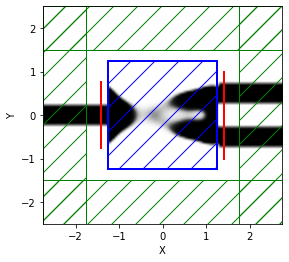

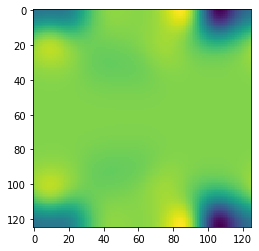

Current iteration: 102/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


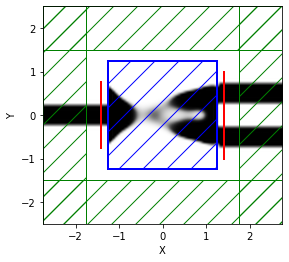

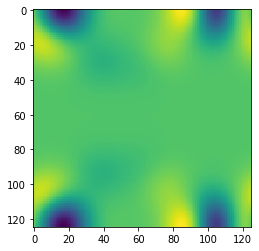

Current iteration: 103/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


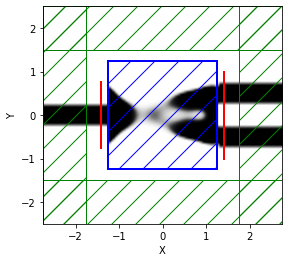

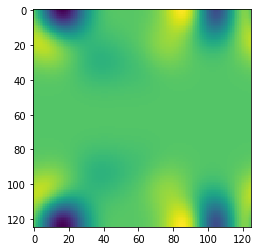

Current iteration: 104/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


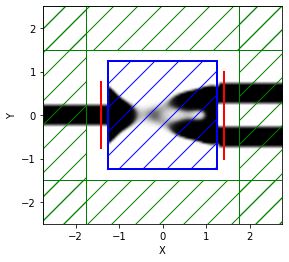

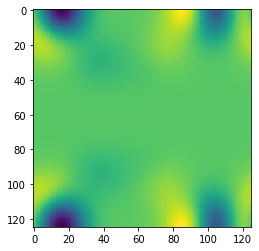

Current iteration: 105/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


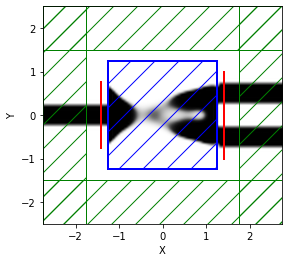

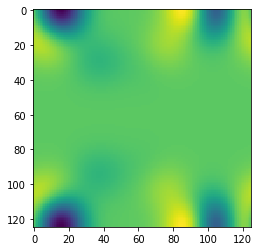

Current iteration: 106/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


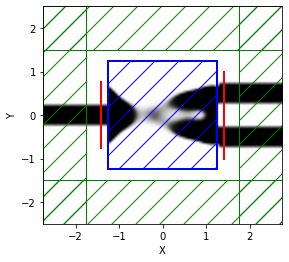

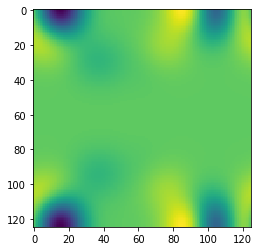

Current iteration: 107/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


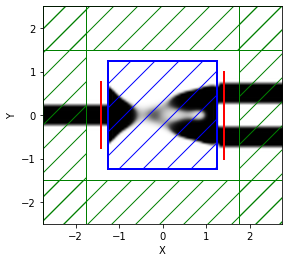

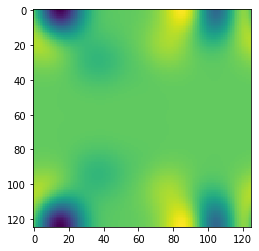

Current iteration: 108/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


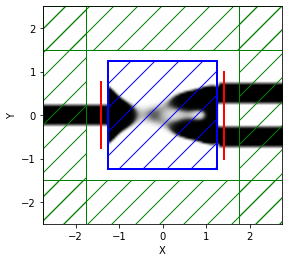

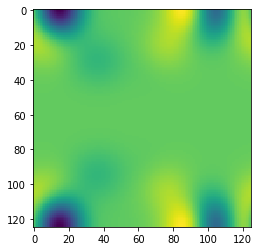

Current iteration: 109/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


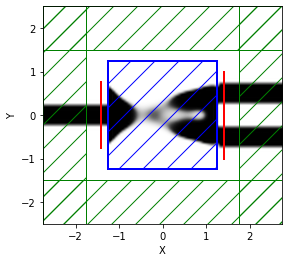

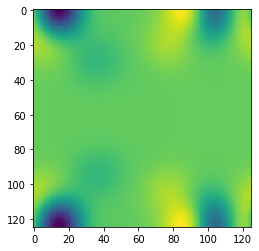

Current iteration: 110/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


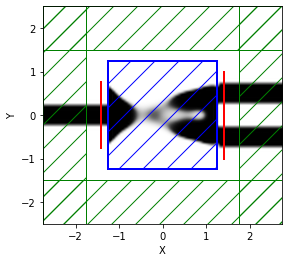

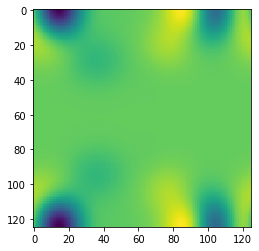

[0.42524831 0.42528584 0.42539474 ... 0.44015294 0.44065108 0.44094553]
Current iteration: 111/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


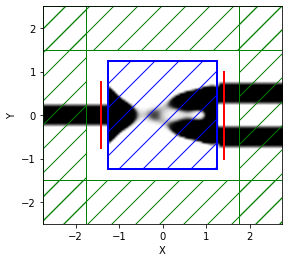

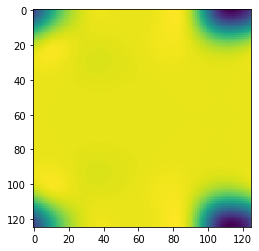

Current iteration: 112/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


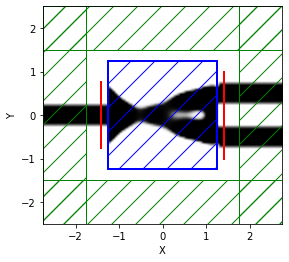

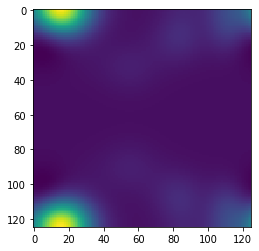

Current iteration: 113/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


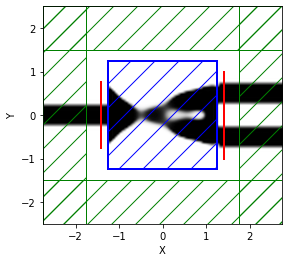

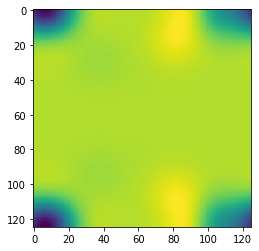

Current iteration: 114/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


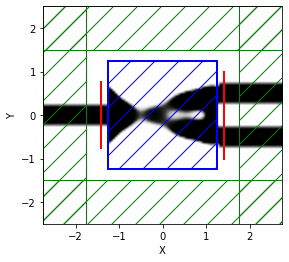

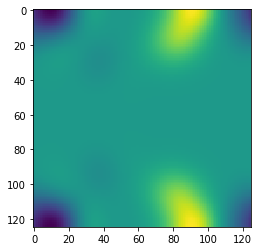

Current iteration: 115/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


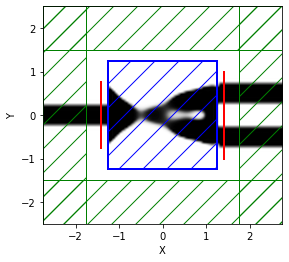

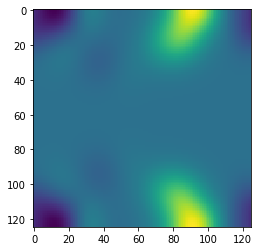

Current iteration: 116/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


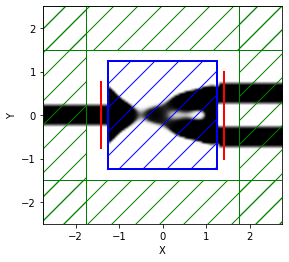

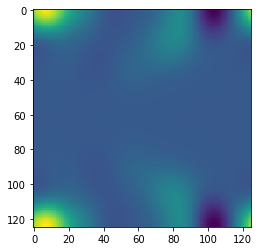

Current iteration: 117/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


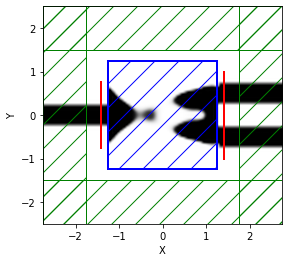

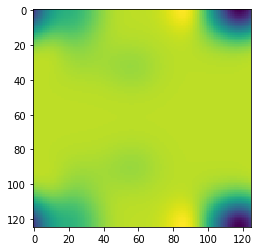

Current iteration: 118/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


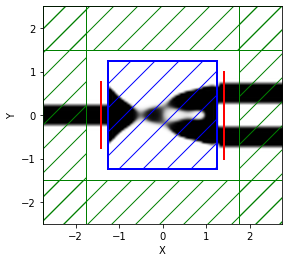

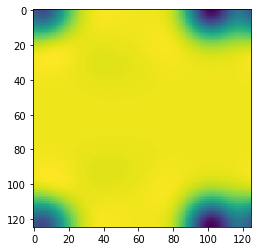

Current iteration: 119/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


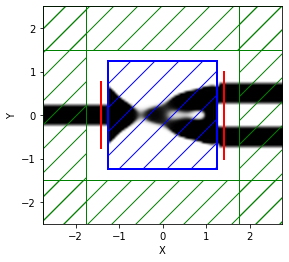

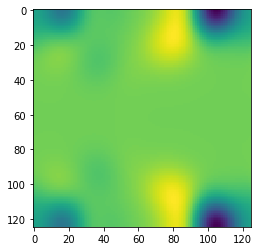

Current iteration: 120/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


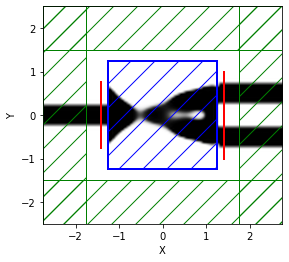

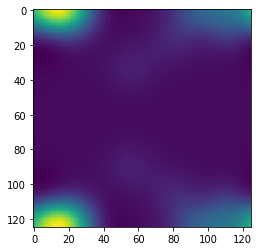

[0.45287906 0.45281022 0.45260194 ... 0.46747321 0.46849976 0.46911512]
Current iteration: 121/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


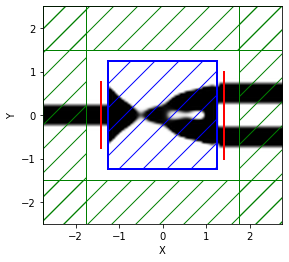

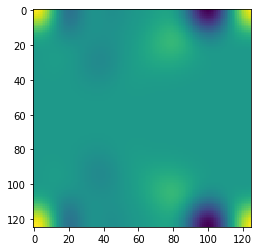

Current iteration: 122/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


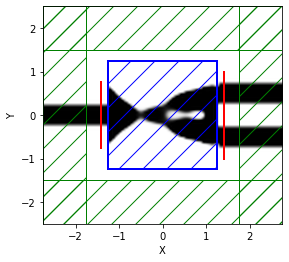

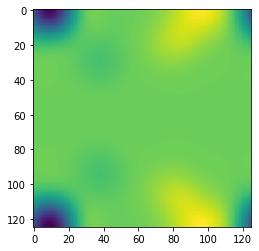

Current iteration: 123/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


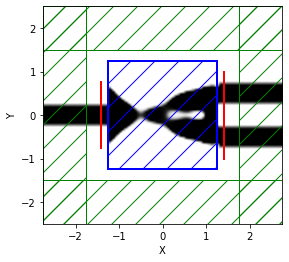

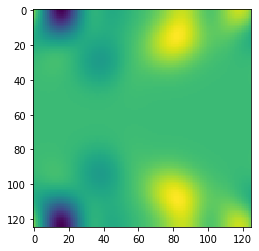

Current iteration: 124/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


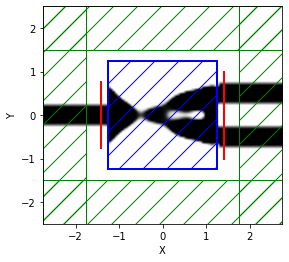

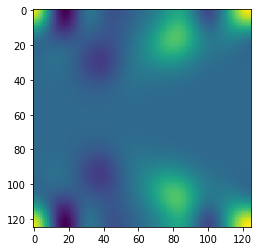

Current iteration: 125/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


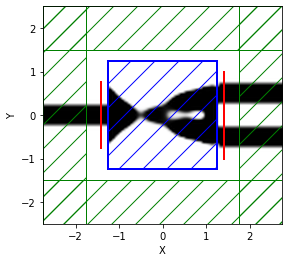

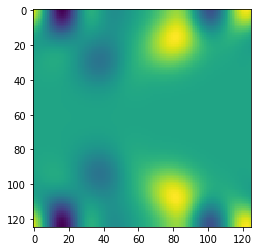

Current iteration: 126/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


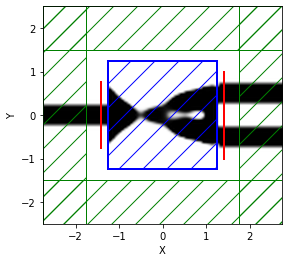

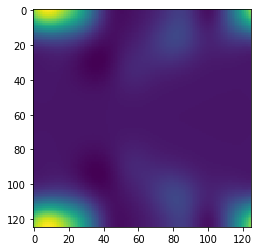

Current iteration: 127/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


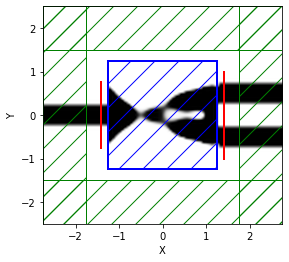

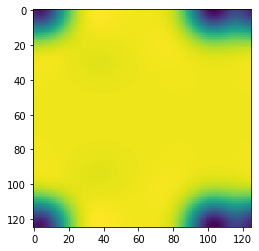

Current iteration: 128/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


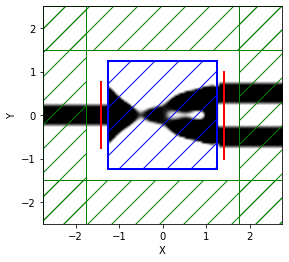

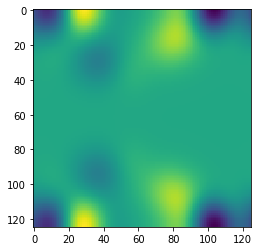

Current iteration: 129/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


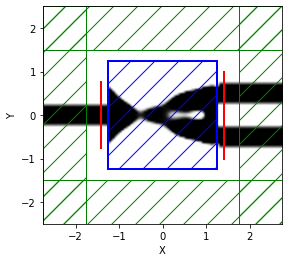

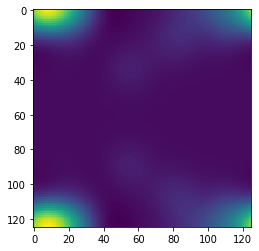

Current iteration: 130/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


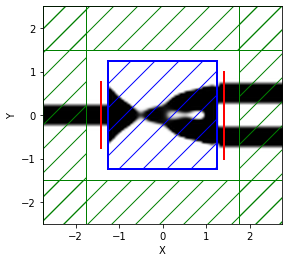

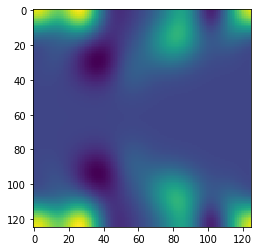

[0.44219853 0.44220265 0.44221075 ... 0.45714354 0.45781795 0.45821721]
Current iteration: 131/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


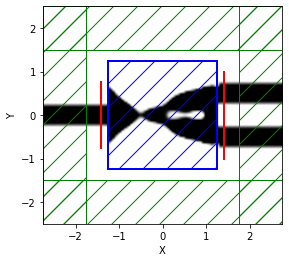

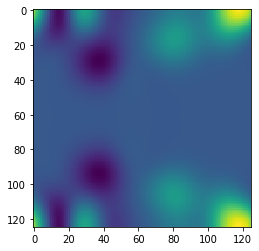

Current iteration: 132/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


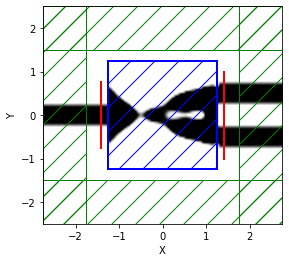

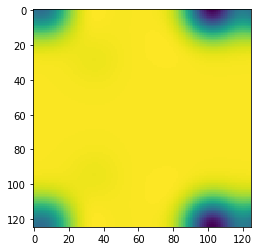

Current iteration: 133/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


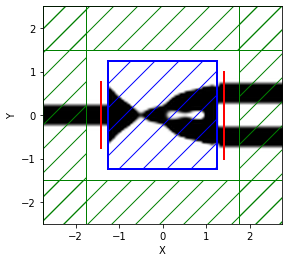

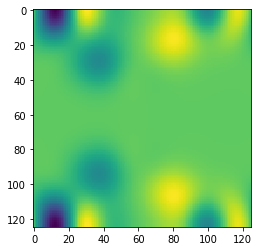

Current iteration: 134/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


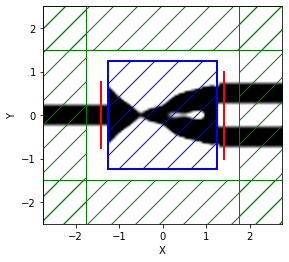

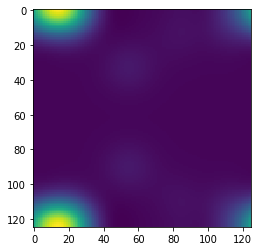

Current iteration: 135/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


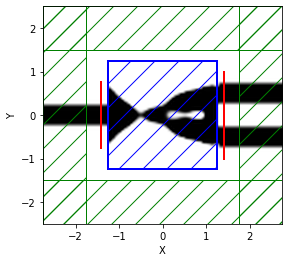

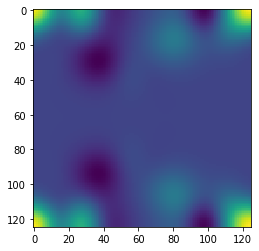

Current iteration: 136/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


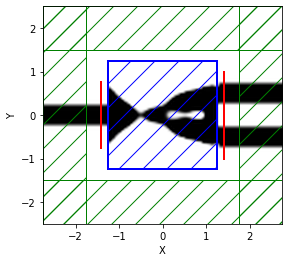

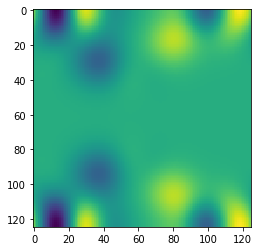

Current iteration: 137/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


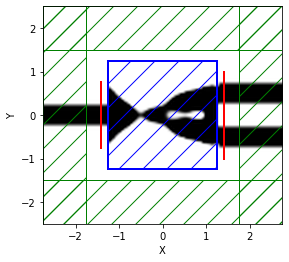

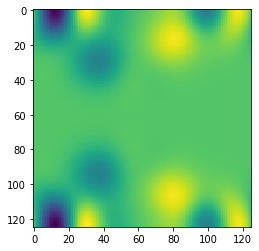

Current iteration: 138/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


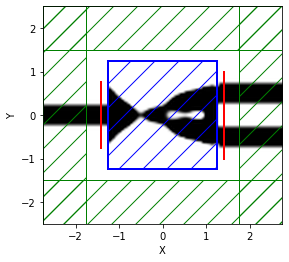

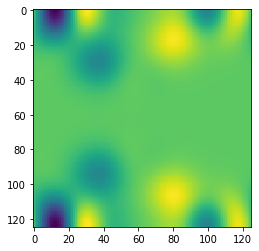

Current iteration: 139/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


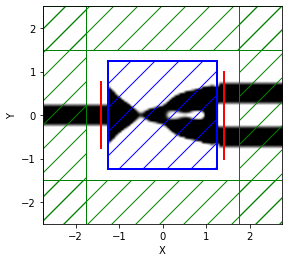

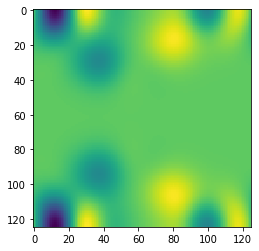

Current iteration: 140/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


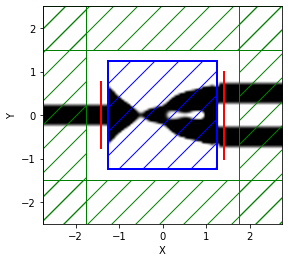

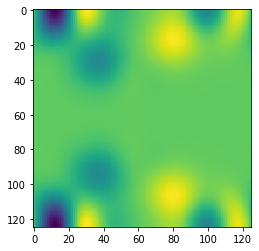

[0.44135194 0.44136151 0.44138578 ... 0.45627381 0.45692118 0.45730387]
Current iteration: 141/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


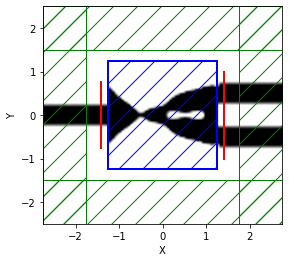

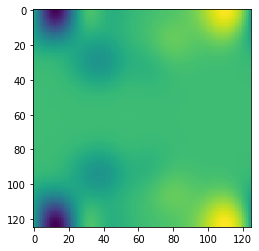

Current iteration: 142/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


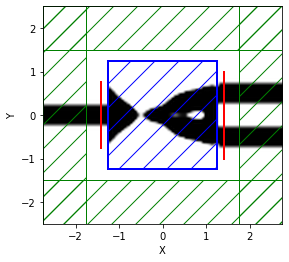

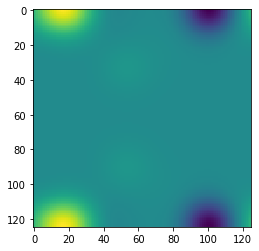

Current iteration: 143/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


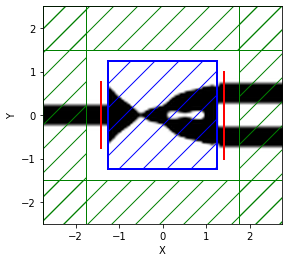

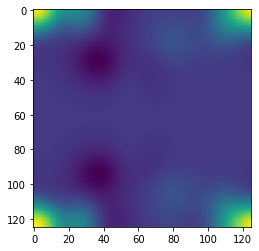

Current iteration: 144/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


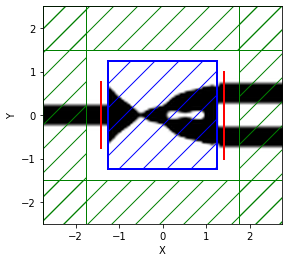

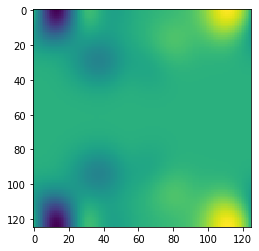

Current iteration: 145/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


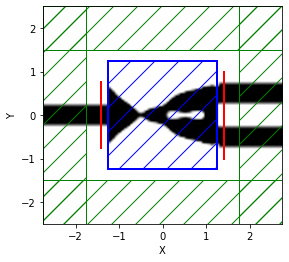

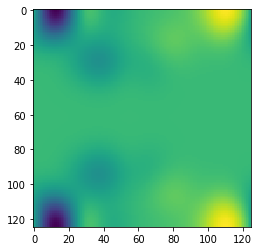

Current iteration: 146/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


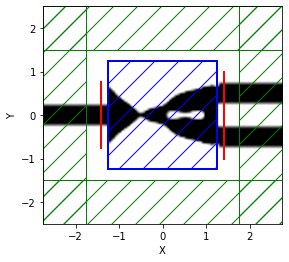

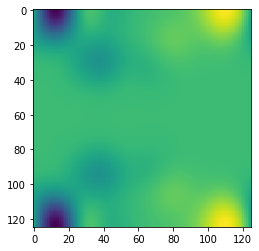

Current iteration: 147/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


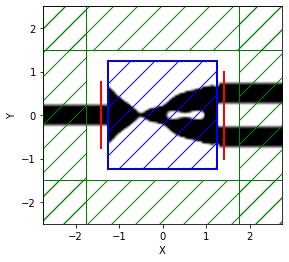

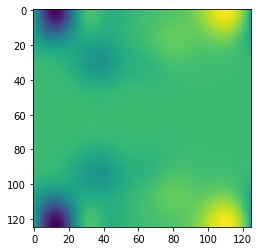

Current iteration: 148/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


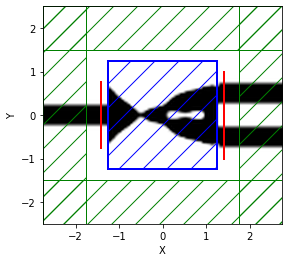

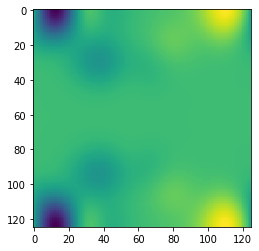

Current iteration: 149/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


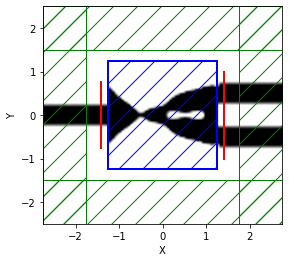

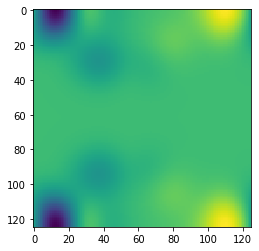

Current iteration: 150/150
Starting forward run...
Starting adjoint run...
Calculating gradient...


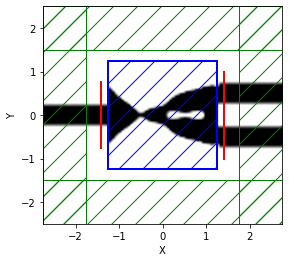

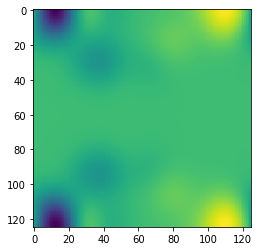

In [11]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
x0 = np.ones((Nx*Ny,)) * 0.0 #np.random.rand(Nx*Ny)
x = np.ones((Nx*Ny,)) * 0.0

cur_beta = beta_start
for iters in range(int(maxeval/update_factor)):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(0)
    solver.set_upper_bounds(1)
    solver.set_min_objective(lambda a,g: f_simple(a,g,cur_beta))
    #solver.add_inequality_mconstraint(c, np.array([1e-6]*frequencies.size))
    solver.set_maxeval(update_factor)
    solver.set_xtol_rel(1e-4)
    x[:] = solver.optimize(x0)
    x0[:] = x
    cur_beta = cur_beta*beta_scale

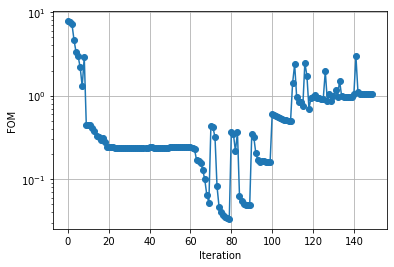

In [12]:
plt.figure()
plt.semilogy(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

In [13]:
print(beta)
opt_val = solver.last_optimum_value()
print(opt_val)
opt.update_design([mapping(x,sigma,delta,cur_beta)])

[1]
1.0506628169367163


/home/alechammond/miniconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [14]:
f0, dJ_deps, dg = opt([mapping(x,sigma,delta,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2

Starting forward run...


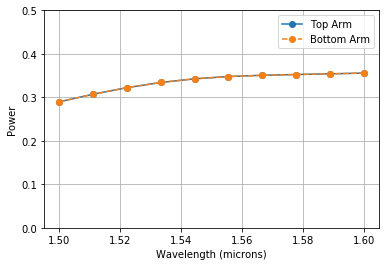

[0.28968787 0.3071658  0.32225004 0.33416104 0.3426028  0.34782537
 0.35069254 0.35245134 0.35405857 0.35577643]


In [15]:
plt.figure()
plt.plot(1/frequencies,top_profile,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power')
plt.ylim(0,0.5)
plt.show()
print(top_profile)

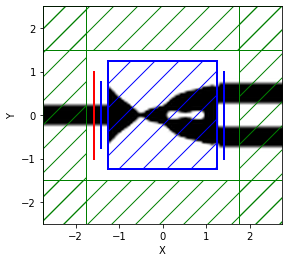

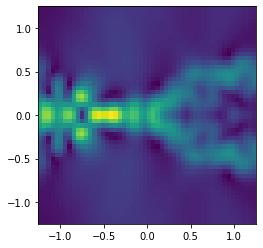

[array([2.085136, 2.085136, 2.085136, ..., 2.085136, 2.085136, 2.085136])]


In [16]:
plt.figure()
opt.plot2D(True)
plt.figure()
ez = np.squeeze(opt.d_E[0][:,:,:,2,opt.fcen_idx])
plt.imshow(np.abs(np.rot90(ez)),extent=[-design_region_width/2,design_region_width/2,-design_region_height/2,design_region_height/2])
plt.show()
print([mapping(final_inputs,sigma,delta,cur_beta)])